In [1]:
import sys
import time
import pickle
import numpy as np
import pandas as pd

from multiprocessing import Pool

from skimage import io
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras 
from keras.models import Sequential, Model, load_model
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from scripts.image import load_image

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 224, 224

In [3]:
images_preloaded = True
try:
    with open('data/images.pickle', 'rb') as handle:
        features, labels =  pickle.load(handle)
except:
    images_preloaded = False

In [4]:
# load images into memory
if(not images_preloaded):
    with open('data/tmdb_info.pickle', 'rb') as handle:
        tmdb_dict =  pickle.load(handle)
    with Pool(6) as p:
        rs = p.map_async(load_image, list(tmdb_dict.keys()))
        p.close()
        while (True):
            if (rs.ready()): break
            remaining = rs._number_left
            print("Waiting for", remaining, "tasks to complete...")
            time.sleep(10)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 23 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 14 tasks to complete...
Waiting for 11 tasks to complete...
Waiting for 7 tasks to complete...
Waiting for 2 tasks to complete...


In [5]:
max_labels = 1

In [6]:
# extract labes for the loaded images
if(not images_preloaded):
    labels = []
    features = []
    for r in rs.get():
        if(r[1] is not None):
            movie_genres = tmdb_dict[r[0]].__dict__['genres']
            if(movie_genres is None or len(movie_genres) == 0):
                continue
            labels.append(' '.join([g['name']  for g in movie_genres[:max_labels]]))
            features.append(r[1])
    features = np.asarray(features)
    rs = None

In [7]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)
y = np_utils.to_categorical(y_encoded)
output_size = y.shape[1]

In [8]:
class_freq = y.sum(axis = 0)
class_weight = {k: v for k, v in enumerate(class_freq.max()/class_freq)}
class_weight

{0: 3.431862745098039,
 1: 9.7168632893823741,
 2: 4.8332758025543665,
 3: 1.3453112990007687,
 4: 8.1312427409988377,
 5: 1.8617205158888446,
 6: 1.0,
 7: 10.022906227630637,
 8: 17.265104808877929,
 9: 52.441947565543074,
 10: 29.049792531120332,
 11: 4.5953396783721692,
 12: 4.4170347003154573,
 13: 20.651917404129794,
 14: 6.9316831683168321,
 15: 16.708830548926013,
 16: 22.26073131955485,
 17: 6.9557873820168901,
 18: 28.870103092783506,
 19: 15.269356597600872}

In [9]:
# split into test / train data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state = 540,  stratify = y)

In [10]:
print('Train label matrix shape:', y_train.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (44118, 20)
Train predictor matrix shape: (44118, 224, 224, 3)
Test label matrix shape: (14707, 20)
Test predictor matrix shape: (14707, 224, 224, 3)


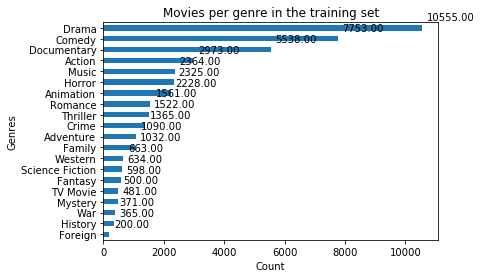

In [11]:
label_df = pd.DataFrame(y_train)
label_df.columns = encoder.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

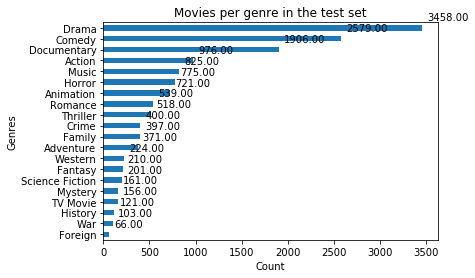

In [12]:
label_df = pd.DataFrame(y_test)
label_df.columns = encoder.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

In [19]:
def create_v3():
    input_shape = (224, 224, 3)

    base_model = InceptionV3(
        input_shape = input_shape, 
        weights='imagenet', 
        include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(output_size, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [20]:
pre_loaded = False
try:
    model = load_model('models/cnn_v3_1.h5')    
    pre_loaded = True
except:
    model = create_v3()

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_95 (Conv2D)               (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 111, 111, 32)  96                                           
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

In [22]:
earlyStopping = EarlyStopping(
    monitor='val_acc', patience = 5, min_delta = 0.01, verbose = 0, mode = 'max')

In [23]:
if(not pre_loaded):
    # rough train the output layer
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])        
    history = model.fit(
        X_train, 
        y_train, 
        class_weight = class_weight,
        batch_size = 256, 
        epochs = 10, 
        verbose = 1,
        validation_data = (X_test, y_test),
        callbacks = [earlyStopping]
    )

Train on 44118 samples, validate on 14707 samples
Epoch 1/10
44118/44118 [==============================] - 505s - loss: 14.9216 - acc: 0.0824 - val_loss: 3.0678 - val_acc: 0.0783
Epoch 2/10
44118/44118 [==============================] - 496s - loss: 12.7415 - acc: 0.1346 - val_loss: 2.8700 - val_acc: 0.1184
Epoch 3/10
44118/44118 [==============================] - 496s - loss: 11.9767 - acc: 0.1566 - val_loss: 3.1077 - val_acc: 0.0728
Epoch 4/10
44118/44118 [==============================] - 496s - loss: 11.2225 - acc: 0.1817 - val_loss: 3.0012 - val_acc: 0.1151
Epoch 5/10
44118/44118 [==============================] - 500s - loss: 10.4369 - acc: 0.2067 - val_loss: 2.8004 - val_acc: 0.1384
Epoch 6/10
44118/44118 [==============================] - 511s - loss: 9.6175 - acc: 0.2323 - val_loss: 2.5203 - val_acc: 0.1679
Epoch 7/10
44118/44118 [==============================] - 496s - loss: 8.7255 - acc: 0.2648 - val_loss: 2.7643 - val_acc: 0.1747
Epoch 8/10
44118/44118 [==================

In [24]:
model.save('models/cnn_v3_1.h5')

In [25]:
# fine train the top 2 inception blocks
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

In [26]:
model.compile(
    optimizer=SGD(lr = 0.0001, momentum=0.9), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [27]:
history = model.fit(
    X_train, 
    y_train, 
    class_weight = class_weight,
    batch_size = 256,
    epochs = 50, 
    verbose = 1,
    validation_data = (X_test, y_test),
    callbacks = [earlyStopping]
)

Train on 44118 samples, validate on 14707 samples
Epoch 1/50
44118/44118 [==============================] - 678s - loss: 4.8735 - acc: 0.4680 - val_loss: 2.0432 - val_acc: 0.3625
Epoch 2/50
44118/44118 [==============================] - 669s - loss: 3.2212 - acc: 0.5691 - val_loss: 1.8991 - val_acc: 0.4154
Epoch 3/50
44118/44118 [==============================] - 668s - loss: 2.5785 - acc: 0.6306 - val_loss: 1.8271 - val_acc: 0.4477
Epoch 4/50
44118/44118 [==============================] - 667s - loss: 2.1828 - acc: 0.6737 - val_loss: 1.7670 - val_acc: 0.4722
Epoch 5/50
44118/44118 [==============================] - 669s - loss: 1.8803 - acc: 0.7098 - val_loss: 1.7234 - val_acc: 0.4945
Epoch 6/50
44118/44118 [==============================] - 668s - loss: 1.6389 - acc: 0.7405 - val_loss: 1.6898 - val_acc: 0.5110
Epoch 7/50
44118/44118 [==============================] - 667s - loss: 1.4487 - acc: 0.7674 - val_loss: 1.6625 - val_acc: 0.5287
Epoch 8/50
44118/44118 [=======================

In [28]:
y_pred_proba = model.predict(X_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [30]:
print(classification_report(y_test, y_pred_test, target_names = encoder.classes_))

                 precision    recall  f1-score   support

         Action       0.68      0.57      0.62       976
      Adventure       0.81      0.53      0.64       371
      Animation       0.75      0.71      0.73       721
         Comedy       0.71      0.62      0.66      2579
          Crime       0.80      0.50      0.61       400
    Documentary       0.73      0.65      0.69      1906
          Drama       0.69      0.61      0.65      3458
         Family       0.80      0.59      0.68       397
        Fantasy       0.82      0.47      0.60       210
        Foreign       0.97      0.58      0.72        66
        History       0.88      0.57      0.69       121
         Horror       0.72      0.56      0.63       775
          Music       0.83      0.59      0.69       825
        Mystery       0.91      0.55      0.69       161
        Romance       0.86      0.56      0.68       539
Science Fiction       0.90      0.60      0.72       201
       TV Movie       0.88    

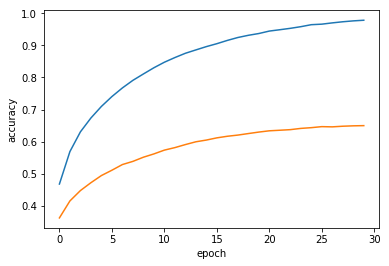

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [32]:
model.save('models/cnn_v3_1.h5')